In [1]:
##### from IPython.display import display, Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### 词向量表示方法：

 #### One-Hot Repression
- 假设词典中不同词的数量为N，每个词从0到N−1的连续整数一一对应。假设一个词的相应整数表示为i，为了得到该词的one-hot向量表示，我们创建一个全0的长为N的向量，并将其第i位设成1，即向量的长度为词典大小。假设词典包含300个词，可乐为[000100...]，1表示可乐在词典中的位置，其余都为0，七喜为[00000010...]。每个词在词典向量(300维)中只有一个为1，代表该词的词向量；
- 但这种方法有两个缺点。第一容易受维数灾难的困扰，比如当词典包含词有十几万个时。第二不能表示两个词之间的相似度，比如可乐和七喜存在相似性，但使用One-Hot Repression，则每个词向量两两正交的，余弦相似度为0。

 #### Distributed Representation
 - 直接用一个普通向量表示一个词，这种向量表示形式一般为: [0.56, -0.89, -0.123, ...]，维度以50维和100维比较常见；
 - 而怎么将一个词表示成一种分布形式的向量，需要用到模型进行训练，word2vec是其中一种。
 - 通过训练得到的词向量一般是有空间上的意义，即将所有这些向量放在一起形成一个词向量空间，而每一向量则为该空间中的一个点，在这个空间上的词向量之间的距离度量也可以表示对应的两个词之间的"距离"。所谓两个词之间的"距离"，就是这两个词之间的语法，语义之间的相似性。每个词的词向量不同，并且相似的词，其词向量间的余弦相似度较大。

### 语言模型
　　给定一个T个词的字符串s，看它是自然语言的概率P($w_{1}$, $w_{2}$, ..., $w_{t}$)。$w_{1}$到$w_{t}$依次表示这句话中的各个词，即：$$p(w_{1},w_{2},...,w_{T}) = p(w_{1})p(w_{2}|w_{1})p(w_{3}|w_{1},w_{2})...p(w_{t}|w_{1},w_{2},...,w_{T-1})$$ 

　　以"大家喜欢吃苹果"为例，总共四个词"大家"，"喜欢"，"吃"，"苹果"，这句话为自然语言的概率是：
- p(大家，喜欢，吃，苹果)=p(大家)p(喜欢 | 大家)p(吃 | 大家，喜欢)p(苹果 | 大家，喜欢，吃);
- p(大家)表示"大家"这个词在语料库里面出现的概率；
- p(喜欢|大家)表示"喜欢"这个词出现在"大家"后面的概率;
- p(吃|大家，喜欢)表示"吃"这个词出现在"大家喜欢"后面的概率；
- p(苹果|大家,喜欢,吃)表示"苹果"这个词出现在"大家喜欢吃"后面的概率。

　　把这些概率连乘起来，得到的就是这句话平时出现的概率。最大化该概率即是最大化似然函数，如果概率超过一定阈值，表明这句话是正常语句。为了表示简单，将上面的公式表示为：$$p(s) = p(w_{1}, w_{2}, ..., w_{T})=\prod_{i=1}^{T}p(w_{i} | Context_{i})$$
　　其中Context(i)为空的话，就是它自己p(w)，另外如"吃"的Context就是"大家"、"喜欢"，以此类推。

###  Continuous Bag-of-Word Model(连续词袋模型)

####  One-word context
　　从最简单的版本开始，假设每个文本(context)只考虑一个词(word)，即给定一个context word，预测一个target word，就像bigram模型。换句话说，给定文本序列"the", "man", "hit", "his", 和"son"，连续词袋模型所关心的是，给定文本序列”the”, “man”, “hit”, “his”, 和”son”，连续词袋模型所关心的是，邻近词“the”, “man”, “his”, 和”son”一起生成中心词”hit”的概率。在这个例子中，"hit"叫中心词，"the", "man", "his", 和"son"叫背景词。由于"hit"只生成与它距离不超过2的背景词，该时间窗口的大小为2。现在只考虑一个词，以"his"为背景词，预测中心词"son"的概率。词典(vocabulary)大小为V，隐藏层大小为N。如下图，网络为全连接层:

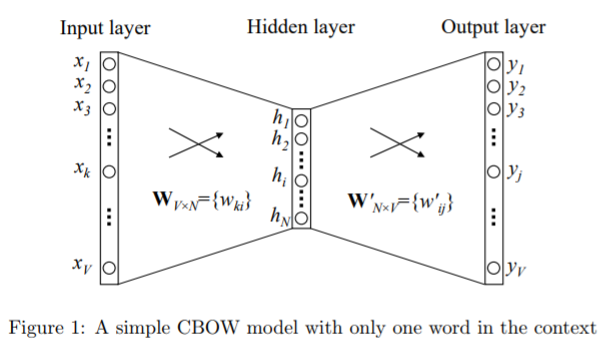

In [2]:
Image('https://raw.githubusercontent.com/martin-1992/deep-learning-note/\
master/word2vec/Word2vec01.png')

　　输入是one-hot encode向量，表示在给定词典大小的$V$个单元中，{$x_{1}$, ... , $x_{v}$}中只有其中一个为1，其余为0，如雪糕为{000001000...}。图中$W_{V x N}$表示输入层到隐藏层的权重，其大小为V x N。矩阵$W$的每行（总共有$V$行）是输入层的相关词的N维向量表示$v_{w}$。即，W的第i行为$v_{w}^{T}$，其大小为1 x N。给定一个文本(词)，假设$ x_{k}=1$，$x_{k'}=0$，且$k'\neq \ k$，即输入词向量中只有一个为1，其余k'为0，如{0000010000...}：
$$\mathbf{h} = W^{T} x = W_{(k, \cdot)}^{T} := \mathbf{v}_{w_{I}}^{T}$$

　　这实质上是将权重W的第k行复制到隐藏层h，因为x为{0000010000...}，乘以权重W，表示输出权重W的第k行，$v_{w_{I}}$是输入词（背景词）$w_{I}$的词向量表示。可推断出隐藏层单元的激活函数是简单的线性（直接将输入层的权重和传递到下一层）。从隐藏层到输出层，则是另外一个权重矩阵${W}'=\{{W}'_{ij}\}$，其大小为N x V，将词向量乘以该权重矩阵，计算出每个词的分数$u_{j}$:
$$u_{j}={v_{w_{j}}}'^{T}h={v_{w_{j}}}'^{T}v_{w_{I}}$$

　　其中${v_{w_{j}}}'$表示权重矩阵${W}'$的第 j 列，然后使用softmax，计算每个词的后验概率，它是一个多项分布。$y_{j}$是输出层的第 j 个单元的输出，在结合前面两项：
$$p(w_{j} | w_{I}) = y_{j} = \frac{\exp(u_{j})}{\sum_{j'=1}^{V}\exp(u_{j'})}=\frac{\exp({v_{w_{j}}}'^{T} v_{w_{I}})}{\sum_{j'=1}^{V}\exp({v_{w_{j'}}}'^{T}v_{w_{I}})}$$

　　注意$v_{w}$和$v'_{w}$是词$w$的两种词向量表示，$v_{w}$是W的第 k 行，表示输入层到隐藏层的权重矩阵，它的向量表示为背景词的向量表示。而$v'_{w}$是W'的第 j 列，表示隐藏层到输出层的权重矩阵，它的向量表示为中心词的向量表示。在随后分析中，将$v_{w}$称为词$w$的输入词（背景词）的向量表示，$v'_{w}$称为词$w$的输出词（中心词）的向量表示。

#### 更新隐藏层到输出层的权重$w^{'}$，更新输出词（中心词）的词向量表示
　　给定输入词（背景词） $w_{I}$ 计算观察到的输出词（中心词） $w_{O}$的条件概率，使用$\log$将最大似然函数转为最大化对数损失函数：
$$ \text {max} \ p(w_{O} | w_{I}) \\
= \text {max} \ y_{j^{*}}\\
=\text {max} \ \log \ y_{j^{*}}\\
= \text {max} \log \ (\frac{ \text{exp}(u_{j^{*}})}{\sum_{j'=1}^{V} \text{exp}(u_{j^{'}})})\\
= u_{j^{*}} - \log \sum_{j'=1}^{V} \text{exp}(u_{j^{'}}) \ := -E$$

　　其中$E=-log \ p(w_{o} | w_{I})$ 是损失函数，即最大化似然函数转为最小化损失函数E，而$j^{*}$是输出层的实际输出词的索引。注意，这种损失函数可以理解为两个概率分布之间交叉熵测量的特例。以一个训练样本为例，对损失函数E，求第j个输入节点网络的分数$u_{j}$的梯度：
$$\frac{\partial E}{\partial u_{j}} = \frac{\partial (\text{log} \sum_{j'=1}^{V} \text{exp}(u_{j^{'}}) - u_{j^{*}})}{\partial u_{j}} \\
=\frac{\partial (\text{log} \sum_{j'=1}^{V} \text{exp}(u_{j^{'}}))}{\partial u_{j}} - t_{j} \\
=\frac{1}{\sum_{j'=1}^{V} \text{exp}(u_{j^{'}})} \times \frac{\partial (\sum_{j'=1}^{V} \text{exp}(u_{j^{'}}))}{\partial u_{j}} - t_{j}\\
=\frac{\text{exp}(u_{j})}{\sum_{j'=1}^{V} \text{exp}(u_{j^{'}})} - t_{j}\\
=y_{j} - t_{j} := e_{j}$$

　　其中$t_{j} = \text{1} \ (j=j^{*})$，举例，当第j个单元为实际输出词时，$t_{j}=1$，否则$t_{j}=0$。注意，这个求导公式为输出层的预测误差$e_{j}$。接下来，求隐藏层到输出层的权重$w_{ij}^{'}$的梯度：
$$\frac{\partial E}{\partial w_{ij}^{'}} = \frac{\partial E}{\partial u_{j}} \cdot \frac{\partial u_{j}}{\partial w_{ij}^{'}}=e_{j}\cdot \frac{\partial v_{w_{j}}'^{T} h}{\partial w_{ij}^{'}}= e_{j}\cdot \frac{\partial v_{w_{ij}}'^{T} h_{i}}{\partial w_{ij}^{'}} =e_{j}\cdot h_{i}$$

　　因此，使用SGD更新隐藏层到输出层的权重参数：
$$ v_{w_{ij}}'^{(new)} =  v_{w_{ij}}'^{(old)} - \eta \cdot e_{j}\cdot h_{i}$$

　　或者是：
$$ v_{w_{ij}}'^{(new)} =  v_{w_{ij}}'^{(old)} - \eta \cdot e_{j}\cdot \text {h} \ \ \ \  for \  j=1,2, ..., V$$

　　其中$\eta$为学习速率，$e_{j}=y_{j} - t_{j}$，$h_{i}$是隐藏层的第 i 个单元，$v_{w_{ij}}'$是$w_{j}$的输出向量。注意这个参数更新等式需要遍历词典中的每个词，检查每个$y_{j}$的输出概率，将概率值$y_{j}$与实际输出$t_{j}$进行比较 。假设$t_{j}$为1，$y_{j}$的概率值越接近1，表示误差越小；相反当$t_{j}$为0，$y_{j}$的概率值越接近0，表示误差越小。

#### 更新输入层到隐藏层的权重$w$，更新输入词（背景词）的词向量表示
　　求E对隐藏层输出$h_{i}$的梯度：
$$\frac{\partial E}{\partial h_{i}}=\sum_{j=1}^{V}\frac{\partial E}{\partial u_{j}}\cdot \frac{\partial u_{j}}{\partial h_{i}}=\sum_{j=1}^{V} e_{j}\cdot w_{ij}^{'} := \text {EH}_{i}$$

　　其中$h_{i}$是隐藏层的第 i 个单元的输出；$u_{j}={v_{w_{j}}}'^{T}h$，为输出层的第 j 个单元的网络输入；$e_{j}=y_{j} - t_{j}$是输出层中第 j 个词的预测误差。$\mathbf{EH}$，为N维向量，是词典中所有词的输出向量的和，由预测误差进行加权。接下来，求损失函数$E$对输入层到隐藏层的权重$W$的梯度，隐藏层的权重表达式为：
$$h_{i}=\sum_{k=1}^{V} x_{k} \cdot w_{ki}$$

　　损失函数$E$对输入层到隐藏层的权重$W$的梯度：
$$\frac{\partial E}{ \partial w_{ki}}=\frac{\partial E}{ \partial h_{i}} \cdot \frac{\partial h_{i}}{ \partial w_{ki}} = \text {EH}_{i} \cdot x_{k}$$

　　矩阵大小为V x N，写成张量形式为：
$$\frac{\partial E}{ \partial \text {W}}=x\bigotimes \text {EH}= \text {xEH}^{T}$$

　　因为$\text {x}$向量只有一个元素为1，即{00010000...}，$\frac{\partial E}{ \partial \text {W}}$中只有一行为非零的，这行的值为$\text {EH}^{T}$，为一个N维向量。更新输入层到隐藏层的权重等式为：
$$ v_{w_{I}}^{(new)} =  v_{w_{I}}^{(old)} - \eta \text {EH}^{T}$$

　　其中$v_{w_{I}}$是$\text {W}$的第 i 行，即输入向量，因为为one-hot encoder，所以求导后$\text {W}$只有一行为非零的，这样在参数更新迭代时，$\text {W}$的其它行都不会改变的。直观上来说，因为向量$\text {EH}$是词典中所有词的预测误差$e_{j}=y_{j} - t_{j}$的加权的输出向量之和，上式就是将词典表中每个输出向量的一部分添加到文本词的输入向量中。当我们通过遍历从训练语料库生成的context-target词对模型参数进行迭代更新时，对向量的影响将会累积。

#### Multi-word context

　　假设输入文本有多个词，如下图的CBOW。当计算隐藏层的输出时，CBOW模型是使用所有输入文本词向量的平均值，而不是每个文本词向量的值，使用输入层到隐藏层的权重矩阵的内积作为隐藏层的输入词（背景词）的词向量，为词向量的平均值：
$$\text {h} = \frac{1}{C} \text {W}^{T}(x_{1} + x_{2} + ... + x_{C})\\
=\frac{1}{C} (v_{w_{1}} +v_{w_{2}} + ... + v_{w_{C}})^{T}$$

　　其中C是文本中输入词（背景词）的个数，$w_{1},...,w_{C}$是文本中所有的输入（背景）词，$v_{w}$是输入词（背景词）$ｗ$的词向量。损失函数为：
$$E = -\text {log} \ p(w_{O} | w_{I1}, ... , w_{IC})\\
= -u_{j*}+\text {log} \sum_{j'=1}^{V} \exp {u_{j'}}\\
= -v_{w_{O}}'^{T} \cdot \text {h} + \text {log} \sum_{j'=1}^{V} \text {exp} ( -v_{w_{j}}'^{T} \cdot \text {h})$$

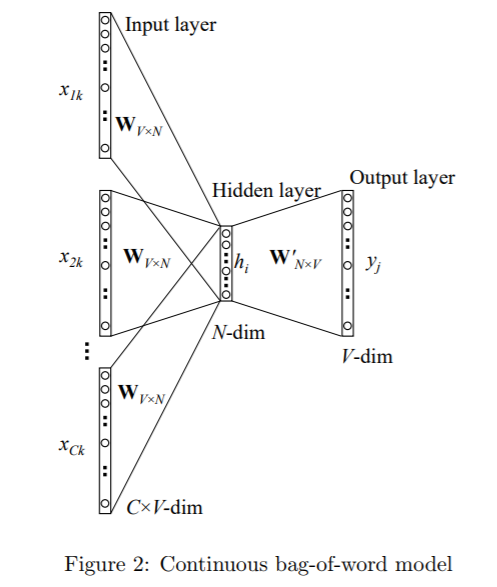

In [2]:
Image('https://raw.githubusercontent.com/martin-1992/deep-learning-note/\
master/word2vec/Word2vec03.png')

　　公式跟之前的文本为一个词的CBOW类似，除了隐藏层的词向量$\text {h}$不同外。隐藏层到输出层的权重更新等式与之前一样：
$$ v_{w_{j}}'^{(new)} =  v_{w_{j}}'^{(old)} - \eta \cdot e_{j} \cdot \text {h} \ \ \ \ for \ j =1,2,...,V$$

　　输入层到隐藏层的权重更新等式也是类似的，除了需要对文本中的每个词$w_{Ic}$运用如下等式：
$$ v_{w_{Ic}}^{(new)} =  v_{w_{Ic}}^{(old)} - \frac{1}{\text {C}}  \cdot \eta \cdot \text {EH}^{T} \ \ \ \ for \ c =1,2,...,C$$
　　其中$v_{w_{Ic}}$是输入文本中第 c 个词的输入词向量；$ \eta$为正的学习速率；$\text {EH}=\frac{\partial E}{\partial h_{i}}$ 是E对隐藏层输出的梯度。

#### 总结CBOW模型流程：
- 初始化神经网络，隐藏层的词向量表示为输入词（背景词）的向量表示，输出层的词向量表示为中心词的词向量表示；
- 最大化似然函数$p(w_{O} | w_{I})$，转为最小化对数损失函数$ E = \log \sum_{j'=1}^{V} \text{exp}(u_{j^{'}}) - u_{j^{*}}$；
- 使用梯度下降，对损失函数$E$求隐藏层到输出层权重$w_{ij}'$的梯度：
$$\frac{\partial E}{\partial w_{ij}^{'}} = \frac{\partial E}{\partial u_{j}} \cdot \frac{\partial u_{j}}{\partial w_{ij}^{'}}\\
=(\frac{\text{exp}(u_{j})}{\sum_{j'=1}^{V} \text{exp}(u_{j^{'}})} - t_{j}) \cdot \frac{\partial v_{w_{j}}'^{T} h}{\partial w_{ij}^{'}}\\
=(y_{j} - t_{j}) \cdot h_{i} = e_{j}\cdot h_{i}$$
其中$t_{j} = \text{1} \ (j=j^{*})$，举例，当第j个单元为实际输出词时，$t_{j}=1$，否则$t_{j}=0$。$y_{j}$为预测值，$(y_{j} - t_{j}$为预测误差，当$t_{j}=1$时，$y_{j}$概率值越接近1时，误差越小。$h$为隐藏层的词向量（输出值），当输入词有多个词时，$h$为隐藏层词向量的平均值，即$\text {h} =\frac{1}{C} (v_{w_{1}} +v_{w_{2}} + ... + v_{w_{C}})^{T}$，更新参数，即输出层的输出词（背景词）向量表示：
$$v_{w_{ij}}'^{(new)} =  v_{w_{ij}}'^{(old)} - \eta \cdot e_{j}\cdot h_{i}$$

- 同样使用梯度下降，对$E$求输入层到隐藏层权重$w_{ki}$的梯度：
$$\frac{\partial E}{ \partial w_{ki}}=\frac{\partial E}{ \partial h_{i}} \cdot \frac{\partial h_{i}}{ \partial w_{ki}}\\
=\sum_{j=1}^{V}\frac{\partial E}{\partial u_{j}}\cdot \frac{\partial u_{j}}{\partial h_{i}}  \cdot \frac{\partial h_{i}}{ \partial w_{ki}}\\
=\sum_{j=1}^{V}  (y_{j} - t_{j}) \cdot \frac{\partial v_{w_{ij}}'^{T} h_{i}}{\partial h_{i}} \cdot \frac {\partial w_{ki}^{T} x_{k}}{\partial w_{ki}}\\
=\sum_{j=1}^{V} e_{j}\cdot w_{ij}^{'} \cdot x_{k}\\
=\text {EH}_{i} \cdot x_{k}$$
更新参数，因为$\text {x}$向量只有一个元素为1，即{00010000...}，$\frac{\partial E}{ \partial \text {W}}$中只有一行为非零的，这行的值为$\text {EH}^{T}$。即输入层的背景词向量表示：
$$ v_{w_{I}}^{(new)} =  v_{w_{I}}^{(old)} - \eta \text {EH}^{T}$$
- 不断迭代上面步骤，更新模型参数。

### 跳字模型(skip-gram)

　　跳字模型与CBOW模型相反，用一个词来预测它在文本序列周围的词。例如，给定文本序列"the", "man", "hit", "his", 和"son"，跳字模型所关心的是，给定"hit"，生成它邻近词"the", "man", "his", 和"son"的概率。在这个例子中，"hit"叫中心词，"the", "man", "his", 和"son"叫背景词。由于"hit"只生成与它距离不超过2的背景词，该时间窗口的大小为2。用词向量表示这个中心词以及背景词的向量表达，通过最大似然估计，找向量表达式来最大化似然估计，这样可以找到一套词向量的表达方法。仍然使用$ \text {v}_{w_{I}}$标记输入层中仅有一个词的输入向量，因此隐藏层的输出为：
$$h = W^{T} x = W_{(k, \cdot)}^{T} := v_{w_{I}}^{T}$$

　　其中$\text {h}$是是将权重W的第k行复制到隐藏层h，因为x为{0000010000...}，乘以权重W，表示输出权重W的第k行，$v_{w_{I}}$是隐藏层的输入词（中心词）向量表示。在输出层，是输出C个多项分布，而不是一个多项分布。每个输出使用同样的隐藏层到输出层的矩阵计算而得：
$$p(w_{c, j}=w_{O, c} | w_{I})=y_{c, j}=\frac{exp(u_{c, j})}{\sum_{j'=1}^{V}exp(u_{j'})}$$

In [ ]:
Image('https://raw.githubusercontent.com/martin-1992/deep-learning-note/master/word2vec/Word2vec04.png')

　　$w_{c, j}$是输出层第 c 项的第 j 个词；$w_{O, c}$是输出文本词的第 c 个真实词；$w_{I}$为输入的中心词；$y_{c, j}$是输出层第 c 项的第 j 个单元的输出；$u_{c, j}$是输出层第 c 项的第 j 个单元的网络输入。因为输出层的每项都是共享权重的，因此：
$$u_{c, j}=u_{j}=v_{w_{j}}'^{T} \cdot \text {h}, \ \ \ \  for \  c=1, 2, ... , C$$

　　其中$v_{wj}'$是词典中输出向量的第 j 个词，$v_{wj}'$表示隐藏层到输出层的权重矩阵的第 j 列。损失函数为：
$$E = -\text {log} \ p(w_{O1}, w_{O2}, ..., w_{Oc}  | w_{I})\\
= -\text {log} \prod_{c=1}^{C} \frac{\exp {u_{c ,j_{c}^{*}}}}{\sum_{j'=1}^{V} \exp {u_{j}'}}\\
= -\sum_{c=1}^{C} u_{j_{c}^{*}}+ C \cdot \text {log} \sum_{j'=1}^{V} \text {exp} (u_{j}')$$

　　$j_{c}*$是词典中第 c 个实际输出文本词的索引，E 对输出层每项（移动窗口）的每个网络输入单元$u_{c, j}$的梯度：
$$\frac{\partial E}{\partial u_{c, j}}=y_{c, j}-t_{c, j} := e_{c, j}$$

　　这是一个单元的预测误差，为了符号简单，定义所有的文本词为 V 维向量$\text {EI}={\text {EI}_{1}, ..., \text {EI}_{V}}$作为预测误差的和：
$$\text {EI}_{j}=\sum_{c=1}^{C}e_{c, j}$$

　　接下来对E求隐藏层到输出层的权重矩阵$\text {W}'$，即输出层的输出词（背景词）向量表示：
$$\frac{\partial E}{\partial w_{ij}'}=\sum_{c=1}^{C} \frac{\partial E}{\partial u_{c,j}} \cdot  \frac{\partial u_{c,j}}{\partial w_{ij}'}=\text {EI}_{j} \cdot h_{i}$$

　　隐藏层到输出层的矩阵$\text {W}'$的更新等式为：
$$w_{ij}'^{(new)}=w_{ij}'^{(old)} - \eta \cdot \text {EI}_{j} \cdot {h}_{i}$$
　　或者写成向量形式：
$$v_{w_{j}}'^{(new)}=v_{w_{j}}'^{(old)} - \eta \cdot \text {EI}_{j} \cdot \text {h} \ \ \ \ for \ j=1, 2, ..., V$$

　　注意需要对每个训练实例使用该等式进行更新。输入层到隐藏层的求导等式与之前类似，除了将预测误差$e_{j}$替换为$\text {EI}_{j}$。这里直接给出更新等式：
$$v_{w_{I}}^{(new)} = v_{w_{I}}^{(old)} - \eta \cdot \text {EH}^{T}$$

　　其中$\text {EH}$是N维向量，每个元素定义为：
$$\text {EH}_{i}=\sum_{j=1}^{V} \text {EI}_{j} \cdot w_{ij}'$$

在跳字模型中，我们用一个词来预测它在文本序列周围的词。例如，给定文本序列"the", "man", "hit", "his", 和"son"，跳字模型所关心的是，给定"hit"，生成它邻近词"the", "man", "his", 和"son"的概率。在这个例子中，"hit"叫中心词，"the", "man", "his", 和"son"叫背景词。由于"hit"只生成与它距离不超过2的背景词，该时间窗口的大小为2。用词向量表示这个中心词以及背景词的向量表达，通过最大似然估计，找向量表达式来最大化似然估计，这样可以找到一套词向量的表达方法。

假设词典大小为$|\mathcal{V}|$，我们将词典中的每个词与从0到$|\mathcal{V}|-1$的整数一一对应：词典索引集$\mathcal{V} = {0, 1, \ldots, |\mathcal{V}|-1}$。一个词在该词典中所对应的整数称为词的索引。给定一个长度为$T$的文本序列中，$t$时刻的词为$w^{(t)}$。当时间窗口大小为$m$时，跳字模型需要最大化给定任一中心词生成背景词的概率：

$$ \prod_{t=1}^T \prod_{-m \leq j \leq m, j \neq 0} \mathbb{P}(w^{(t+j)} \mid w^{(t)})$$

上式中，$w^{(t)}$为t时刻的中心词，要生成$w^{(t+j)}$的背景词，j限制为[-m, m]之间，m为为窗口大小。假设m为2，则中心词$w^{(t)}$只计算生成前面两个词$w^{(t-1)}, w^{(t-2)}$和后面两个词$w^{(t+1)}, w^{(t+2)}$的概率。假设用中心词生成每个背景词的条件概率是相互独立的，则使用乘法连接。假设文本序列总长度有T个词，对每个中心词$w^{(t)} \ (t=1, ... t=T)$都进行计算背景词概率。即给定每个时刻中心词，生成该时刻背景词的联合概率。

最大化（联合概率）似然估计等价于最小化损失函数: 
$$max \ \prod_{t=1}^T \prod_{-m \leq j \leq m, j \neq 0} \mathbb{P}(w^{(t+j)} \mid w^{(t)}) \\
max \ \text{log}\prod_{t=1}^T \prod_{-m \leq j \leq m, j \neq 0} \mathbb{P}(w^{(t+j)} \mid w^{(t)})\\
max  \sum_{t=1}^T \sum_{-m \leq j \leq m, j \neq 0} \text{log} \mathbb{P}(w^{(t+j)} \mid w^{(t)})\\
min \ -\frac{1}{T} \sum_{t=1}^T \sum_{-m \leq j \leq m, j \neq 0} \text{log} \mathbb{P}(w^{(t+j)} \mid w^{(t)})$$

跳字模型的损失函数，找到一组中心词和背景词的向量表达式，来最小化损失函数：
$$ -\frac{1}{T} \sum_{t=1}^T \sum_{-m \leq j \leq m, j \neq 0} \text{log} \mathbb{P}(w^{(t+j)} \mid w^{(t)})$$

我们可以用$\mathbf{v}$和$\mathbf{u}$分别代表中心词和背景词的向量。换言之，对于词典中一个索引为$i$的词，它在作为中心词和背景词时的向量表示分别是$\mathbf{v}_i$和$\mathbf{u}_i$。而词典中所有词的这两种向量正是跳字模型所要学习的模型参数。为了将模型参数植入损失函数，我们需要使用模型参数表达损失函数中的中心词生成背景词的概率。假设中心词生成各个背景词的概率是相互独立的。给定中心词$w_c$在词典中索引为$c$，背景词$w_o$在词典中索引为$o$，损失函数中的中心词生成背景词的概率可以使用softmax函数定义为

$$\mathbb{P}(w_o \mid w_c) = \frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)}$$

当序列长度$T$较大时，我们通常随机采样一个较小的子序列来计算损失函数并使用随机梯度下降优化该损失函数。通过微分，我们可以计算出上式生成概率的对数关于中心词向量$\mathbf{v}_c$的梯度为：

$$\frac{\partial \text{log} \mathbb{P}(w_o \mid w_c)}{\partial \mathbf{v}_c}\\
=\frac{\partial (\text{log} \ (\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)) - \text{log} \ (\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)))}{\partial \mathbf{v}_c}\\
=\frac{\partial (\mathbf{u}_o^\top \mathbf{v}_c- \text{log} \ (\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)))}{\partial \mathbf{v}_c}\\
=\mathbf{u}_o - \frac{\partial (\text{log} \ (\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)))}{\partial \mathbf{v}_c}\\
=\mathbf{u}_o - \frac{1}{\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)}\frac{\partial \ (\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c))}{\partial \mathbf{v}_c}\\
=\mathbf{u}_o - \frac{1}{\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)} \sum_{j \in \mathcal{V}} \text{exp}(\mathbf{u}_j^\top \mathbf{v}_c)\mathbf{u}_j\\
=\mathbf{u}_o - \sum_{j \in \mathcal{V}} \frac{\text{exp}(\mathbf{u}_j^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)} \mathbf{u}_j\\
$$

而上式与下式等价：

$$\frac{\partial \text{log} \mathbb{P}(w_o \mid w_c)}{\partial \mathbf{v}_c} = \mathbf{u}_o - \sum_{j \in \mathcal{V}} \mathbb{P}(w_j \mid w_c) \mathbf{u}_j$$

通过上面计算得到梯度后，我们可以使用随机梯度下降来不断迭代模型参数$\mathbf{v}_c$。其他模型参数$\mathbf{u}_o$的迭代方式同理可得。最终，对于词典中的任一索引为$i$的词，我们均得到该词作为中心词和背景词的两组词向量$\mathbf{v}_i$和$\mathbf{u}_i$。注意，单对$\frac{\partial \text{log} \mathbb{P}(w_o \mid w_c)}{\partial \mathbf{v}_c}$进行求导，就涉及整个词典 $\sum_{j \in \mathcal{V}} \mathbb{P}(w_j \mid w_c)$，公式涉及到求和，即需要将每个索引对应词的概率算一遍，其计算开销与词典大小相关。

参数更新：$V_{c} = V_{c} - \frac{\partial Loss}{\partial V_{c}}$

### 连续词袋模型
连续词袋模型与跳字模型类似。与跳字模型最大的不同是，连续词袋模型中用一个中心词在文本序列周围的词来预测该中心词。例如，给定文本序列"the", "man", "hit", "his", 和"son"，连续词袋模型所关心的是，邻近词“the”, "man", "his", 和"son"一起生成中心词"hit"的概率。

假设词典大小为$|\mathcal{V}|$，我们将词典中的每个词与从0到$|\mathcal{V}|-1$的整数一一对应：词典索引集$\mathcal{V} = {0, 1, \ldots, |\mathcal{V}|-1}$。一个词在该词典中所对应的整数称为词的索引。给定一个长度为$T$的文本序列中，$t$时刻的词为$w^{(t)}$。当时间窗口大小为$m$时，连续词袋模型需要最大化由背景词生成任一中心词的概率：

$$max \  \prod_{t=1}^T \mathbb{P}(w^{(t)} \mid w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)})$$

上式的最大似然估计与最小化以下损失函数等价

$$min \  -\sum_{t=1}^T \text{log} \mathbb{P}(w^{(t)} \mid w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)})$$

我们可以用$\mathbf{v}$和$\mathbf{u}$分别代表背景词和中心词的向量（注意符号和跳字模型中的不同）。换言之，对于词典中一个索引为$i$的词，它在作为背景词和中心词时的向量表示分别是$\mathbf{v}i$和$\mathbf{u}i$。而词典中所有词的这两种向量正是连续词袋模型所要学习的模型参数。为了将模型参数植入损失函数，我们需要使用模型参数表达损失函数中的中心词生成背景词的概率。给定中心词$w_c$在词典中索引为$c$，背景词$w{o_1}, \ldots, w{o_{2m}}$在词典中索引为$o_1, \ldots, o_{2m}$，损失函数中的背景词生成中心词的概率可以使用softmax函数定义为

$$\mathbb{P}(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\text{exp}[\mathbf{u}c^\top (\mathbf{v}{o_1} + \ldots + \mathbf{v}{o{2m}}) /(2m) ]}{ \sum_{i \in \mathcal{V}} \text{exp}[\mathbf{u}i^\top (\mathbf{v}{o_1} + \ldots + \mathbf{v}{o{2m}}) /(2m)]}$$


注意，背景词$\mathbf{v}{o_1} + \ldots + \mathbf{v}{o{2m}}$有多个向量，对其求平均，转化为单个向量，即背景词的平均向量。

当序列长度$T$较大时，我们通常随机采样一个较小的子序列来计算损失函数并使用随机梯度下降优化该损失函数。通过微分，我们可以计算出上式生成概率的对数关于任一背景词向量$\mathbf{v}_{o_i}$($i = 1, \ldots, 2m$)的梯度为：

$$\frac{\partial \text{log} \mathbb{P}(w_c \mid w_{o_1}, \ldots, w_{o_{2m}})}{\partial \mathbf{v}_{o_i}} = \frac{1}{2m}(\mathbf{u}c - \sum_{j \in \mathcal{V}} \frac{\text{exp}(\mathbf{u}_j^\top \mathbf{v}c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)} \mathbf{u}_j)$$

而上式与下式等价：

$$\frac{\partial \text{log} \mathbb{P}(w_c \mid w_{o_1}, \ldots, w_{o_{2m}})}{\partial \mathbf{v}_{o_i}} = \frac{1}{2m}(\mathbf{u}c - \sum_{j \in \mathcal{V}} \mathbb{P}(w_j \mid w_c) \mathbf{u}_j)$$

通过上面计算得到梯度后，我们可以使用随机梯度下降来不断迭代各个模型参数$\mathbf{v}_{o_i}$($i = 1, \ldots, 2m$)。其他模型参数$\mathbf{u}_c$的迭代方式同理可得。最终，对于词典中的任一索引为$i$的词，我们均得到该词作为背景词和中心词的两组词向量$\mathbf{v}_i$和$\mathbf{u}_i$。

### 近似训练法
我们可以看到，无论是跳字模型还是连续词袋模型，每一步梯度计算的开销与词典$\mathcal{V}$的大小相关。因为分母为softmax，计算遍历全部词典。显然，当词典较大时，例如几十万到上百万，这种训练方法的计算开销会较大。所以，使用上述训练方法在实践中是有难度的。

我们将使用近似的方法来计算这些梯度，从而减小计算开销。常用的近似训练法包括负采样和层序softmax。

#### 负采样
　　我们以跳字模型为例讨论负采样。负采样的想法比层序softmax更加直接：词典$\mathcal{V}$大小之所以会在目标函数中出现，是因为中心词$w_c$生成背景词$w_o$的概率$\mathbb{P}(w_o \mid w_c)$使用了softmax，而softmax正是考虑了背景词可能是词典中的任一词，并体现在softmax的分母上。这个概率虽然准确，但计算开销太大。<br />
　　为了处理背景词太多导致每次更新迭代需要的计算开销太大，选择从背景词中取一些来更新。显然输出词（背景词）为正样本，还需要抽样一些词作为负样本（因此叫"负采样"）。采样过程需要概率分布，这个可以任意选择。我们叫这个分布为噪声分布，标记为$P_{n}(w)$。通常使用的分布为unigram distribution的3/4次方的分布。

　　在word2vec，使用简化的损失函数，而不是使用产生明确定义的后验多项式分布的负采样形式：
$$E=-\log \sigma (\mathbf{v}_{w_{O}}'^{T} \mathbf{h}) - \sum_{w_{j}\in W_{neg}} \log \sigma (-\mathbf{v}_{wj}'^{T} \mathbf{h})$$
　　其中$W_{O}$为输出词（举例，正样本），$\mathbf{v}_{w_{O}}'$为输出词的词向量；$\mathbf{h}$为隐藏层的词向量：在CBOW模型里$\mathbf{h}=\frac{1}{C} \sum_{c=1}^{C}\mathbf{v}_{wc}$，在跳字模型里$\mathbf{h}=\mathbf{v}_{w_{I}}$；$W_{neg} = \{w_{j} | j=1, ... , K\}$是基于$P_{n}(w)$分布中抽样的一组词，为负样本。负采样下的词向量更新等式，对E求输出单位$w_{j}$的网络输入：
$$ \frac{\partial E}{\partial \mathbf{v}_{w_j}'^{T} \mathbf{h}}=\left\{\begin{matrix}
\sigma (\mathbf{v}_{w_j}'^{T} \mathbf{h}) - 1 & if \ w_{j}=w_{O}\\ 
\sigma (\mathbf{v}_{w_j}'^{T} \mathbf{h}) & if \ w_{j} \in W_{neg}
\end{matrix}\right.\\
=\sigma (\mathbf{v}_{w_j}'^{T} \mathbf{h}) - t_{j}$$

　　$t_{j}$为词$w_{j}$的标签，当$w_{j}$为正样本时，t=1；负样本时，t=0。接下来对E求词$w_{j}$的输出向量：
$$\frac{\partial E}{\partial \mathbf {v}_{w_{j}}'} = \frac{\partial E}{\partial \mathbf{v}_{w_{j}}'^{T} \mathbf{h}} \cdot \frac{\partial \mathbf{v}_{w_{j}}'^{T} \mathbf{h}}{\partial \mathbf {v}_{w_{j}}'} =(\sigma (\mathbf {v}_{w_{j}}'^{T} \mathbf{h}) - t_{j}) \mathbf{h}$$
　　更新隐藏层到输出层的输出词的词向量：
$$\mathbf {v}_{w_{j}}'^{(new)} = \mathbf {v}_{w_{j}}'^{(old)} - \eta (\sigma (\mathbf {v}_{w_j}'^{T} \mathbf{h}) - t_{j}) \mathbf{h}$$

　　只需要将$w_{j} \in w_{O} \cup W_{neg}$替代词典中的每个词，每次随机梯度下降的梯度计算开销将由词典$\mathcal{O}(|\mathcal{V}|)$降为$\mathcal{O}(K)$，即用负采样通过预先设定噪声词大小来替换词典大小，降低分母的计算开销，由词典大小降到噪声词大小。与之前使用softmax的更新等式对比，除了损失函数的求导不同外，其余都一样：
$$ v_{w_{ij}}'^{(new)} =  v_{w_{ij}}'^{(old)} - \eta \cdot e_{j}\cdot h_{i}$$

　　为了将误差反向传播到隐藏层，并更新词的输入向量，需要对损失函数E求隐藏层的输出：
$$\frac{\partial E}{\partial \mathbf{h}} = \sum_{w_{j} \in w_{O} \cup W_{neg}} \frac{\partial E}{\partial \mathbf{v}_{w_{j}}'^{T} \mathbf{h}} \cdot \frac{\partial \mathbf{v}_{w_{j}}'^{T} \mathbf{h}}{\partial \mathbf{h}}\\
=\sum_{w_{j} \in w_{O} \cup W_{neg}} (\sigma (\mathbf{v}_{w_{j}}'^{T} \mathbf{h}) - t_{j}) v_{w_{j}}' := \text {EH}$$
　　更新等式与之前一样，除了$\text {EH}$的定义有所不同外，CBOW的输入层到隐藏层的输入词的词向量更新等式为：
$$$$ v_{w_{Ic}}^{(new)} =  v_{w_{Ic}}^{(old)} - \frac{1}{\text {C}}  \cdot \eta \cdot \text {EH}^{T} \ \ \ \ for \ c =1,2,...,C$$$$
　　在跳字模型中，需要计算每个词的$\text {EH}$的值，将这些$\text {EH}$值求和，放入下面等式，以更新输入层到隐藏层的输入词的词向量：
$$v_{w_{I}}^{(new)} = v_{w_{I}}^{(old)} - \eta \cdot \text {EH}^{T}$$

我们不妨换个角度，假设中心词$w_c$生成背景词$w_o$由以下相互独立事件联合组成来近似

- 中心词$w_c$和背景词$w_o$同时出现在该训练数据窗口
- 中心词$w_c$和第1个噪声词$w_1$不同时出现在该训练数据窗口（噪声词$w_1$按噪声词分布$\mathbb{P}(w)$随机生成，假设一定和$w_c$不同时出现在该训练数据窗口）
- ...
- 中心词$w_c$和第$K$个噪声词$w_K$不同时出现在该训练数据窗口（噪声词$w_K$按噪声词分布$\mathbb{P}(w)$随机生成，假设一定和$w_c$不同时出现在该训练数据窗口）

我们可以使用$\sigma(x) = 1/(1+\text{exp}(-x))$函数来表达中心词$w_c$和背景词$w_o$同时出现在该训练数据窗口的概率，这里以跳字模型为例，其中$\mathbf{v}_c$为中心词,$\mathbf{u}_o$为背景词：
$$\mathbb{P}(D = 1 \mid w_o, w_c) = \sigma(\mathbf{u}_o^\top \mathbf{v}_c)$$

那么，中心词$w_c$生成背景词$w_o$的对数的联合概率可以近似为中心词和背景词同时出现的概率$\mathbb{P}(D = 1 \mid w_o, w_c)$乘以中心词$w_c$和噪声词$w_k$没有出现在当前训练数据集当前时间窗口的概率$\mathbb{P}(D = 0)$，总共有K个噪声词：

$$ \text{log} \mathbb{P} (w_o \mid w_c) = \text{log} [\mathbb{P}(D = 1 \mid w_o, w_c) \prod_{k=1, w_k \sim \mathbb{P}(w)}^K \mathbb{P}(D = 0 \mid w_k, w_c) ]$$



假设噪声词$w_k$在词典中的索引为$i_k$，上式可改写为

$$ \text{log} \mathbb{P} (w_o \mid w_c) = \text{log} \frac{1}{1+\text{exp}(-\mathbf{u}o^\top \mathbf{v}c)} + \sum{k=1, w_k \sim \mathbb{P}(w)}^K \text{log} [1-\frac{1}{1+\text{exp}(-\mathbf{u}{i_k}^\top \mathbf{v}_c)}] $$

因此，有关中心词$w_c$生成背景词$w_o$的损失函数是

$$ - \text{log} \mathbb{P} (w_o \mid w_c) = -\text{log} \frac{1}{1+\text{exp}(-\mathbf{u}o^\top \mathbf{v}c)} - \sum{k=1, w_k \sim \mathbb{P}(w)}^K \text{log} \frac{1}{1+\text{exp}(\mathbf{u}{i_k}^\top \mathbf{v}_c)} $$

当我们把$K$取较小值时，每次随机梯度下降的梯度计算开销将由$\mathcal{O}(|\mathcal{V}|)$降为$\mathcal{O}(K)$，即用负采样通过预先设定噪声词大小来替换词典大小，降低分母的计算开销，由词典大小降到噪声词大小。

我们也可以对连续词袋模型进行负采样。有关背景词$w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}$生成中心词$w_c$的损失函数

$$-\text{log} \mathbb{P}(w^{(t)} \mid w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)})$$

在负采样中可以近似为

$$-\text{log} \frac{1}{1+\text{exp}[-\mathbf{u}c^\top (\mathbf{v}{o_1} + \ldots + \mathbf{v}{o{2m}}) /(2m)]} - \sum_{k=1, w_k \sim \mathbb{P}(w)}^K \text{log} \frac{1}{1+\text{exp}[(\mathbf{u}{i_k}^\top (\mathbf{v}{o_1} + \ldots + \mathbf{v}{o{2m}}) /(2m)]}$$

同样地，当我们把$K$取较小值时，每次随机梯度下降的梯度计算开销将由$\mathcal{O}(|\mathcal{V}|)$降为$\mathcal{O}(K)$。

注：噪声词为词典中的任意一个词，给定一个概率就行，概率被设置在3/4

　　对于CBOW模型和跳字模型，在词典表中存在两种词向量表达形式：输入词向量$\mathbf{v}_{w}$和输出词向量$\mathbf{v}_{w}'$。输入向量训练的计算开销很小的，但学习输出向量的计算开销则很大。从以下等式可知，为了更新$\mathbf{v}_{w}'$，对每个训练实例，不得不遍历词典中的每个词$w_{j}$，使用softmax计算它们的分数$u_{j}$，概率预测$y_{j}$（对于跳字模型为$y_{c,j}$），得出它们的预测误差$e_{j}$（跳字模型为$\mathbf{EI}_{j}$），最后使用预测误差来更新输出词的词向量$\mathbf{v}_{j}'$：
$$ v_{w_{j}}'^{(new)} =  v_{w_{j}}'^{(old)} - \eta \cdot e_{j} \cdot \text {h} \ \ \ \ for \ j =1,2,...,V\\
w_{ij}'^{(new)}=w_{ij}'^{(old)} - \eta \cdot \text {EI}_{j} \cdot {h}_{i}$$

对每个训练实例的所有词都做以上计算，当词典特别大时，是件开销很大的事。为了解决这个问题，直观上就是要限制每个训练实例必须更新的输出向量，一种方法为层序softmax，另一种方法为负采样。这两种方法仅是优化输出向量的更新计算。在接下来的推导中，只关心三个值：
- $E$，新的损失函数；
- $\frac{\partial E}{\partial \mathbf{v}_{w}'}$，输出向量的新的更新等式；
- $\frac{\partial E}{\partial \mathbf{h}}$，预测误差的加权和将被反向传播以更新输入向量。

### 层序softmax

　　层序softmax是计算softmax的一种有效方法。这个模型使用二叉树来表示词典中的所有词。树的叶子节点为词典中的$V$个词，内节点就有$V-1$个。对于每个叶子节点（词向量），存在一条独一无二的路径从根节点到叶子节点，如下图。这条路径用于估计叶节点表示词的概率。

In [ ]:
Image('https://raw.githubusercontent.com/martin-1992/deep-learning-note/master/word2vec/Word2vec05.png')

　　上图为层序softmax模型的一个简单二叉树的例子。白色节点为叶子节点，代表词典中的每个词，黑色节点为内节点。以高亮的路径从根节点到$w_{2}$为例，其路径$L(w_{2})$的长度为4，$n(w, j)$表示从根节点到词$w$上的第$j$个节点。<br />
　　在层序softmax模型中，没有词的输出向量表示。代替词向量的是，每个$V-1$内节点有一个输出向量$\mathbf{v}_{n(w, j)}'$。一个输出词的概率定义为：
$$p(w=w_{O})=\prod_{j=1}^{L(w)-1} \sigma ([n(w, j+1)=ch(n(w, j))] \cdot \mathbf{v}_{n(w, j)}'^{T} \mathbf{h})$$

　　其中$ch(n)$是节点$n$的左子节点，$\mathbf{v}_{n(w ,j)}'$是内节点$n(w, j)$的向量表示（输出向量）；$\mathbf{h}$是隐藏层的输出值（跳字模型里$\mathbf {h}=\mathbf {v}_{w_{I}}$；在CBOW模型里，$\frac{1}{C} \sum_{c=1}^{C} \mathbf{v}_{w_{c}}$）；$[x] = [n(w, j+1)=ch(n(w, j))]$是一个特殊函数定义为：
$$[x] = \left\{\begin{matrix}
1 & if \ x \ is \ true\\ 
-1 & otherwise
\end{matrix}\right.$$

　　通过一个简单例子来直观明白等式，以上图为例，假设想要计算输出词$w_{2}$的概率。将这个概率定义为从根节点到叶子节点开始随机漫步的概率。在每个内节点（包括根节点），需要指定向左和向右的概率。在内节点$n$，定义向左的概率为：
$$p(n, left) = \sigma (\mathbf{v}_{n}'^{T} \cdot \mathbf {h})$$

　　这是由内节点的向量表示和隐藏层的输出值（由输入词的向量表示决定），两者共同决定的。显然内节点$n$向右的概率为：
$$p(n, right) = 1 - \sigma (\mathbf{v}_{n}'^{T} \cdot \mathbf {h}) = \sigma (- \mathbf{v}_{n}'^{T} \cdot \mathbf {h})$$

　　根据上图中从根节点到叶子节点$w_{2}$，可以计算输出词$w_{2}$的概率为：
$$p(w_{2} = w_{O}) =p(n(w_{2}, 1), left) \cdot  p(n(w_{2}, 2), left) \cdot  p(n(w_{2}, 3), right)\\
=\sigma (\mathbf{v}_{n(w_{2}, 1)}'^{T} \cdot \mathbf {h}) \cdot \sigma (\mathbf{v}_{n(w_{2}, 2)}'^{T} \cdot \mathbf {h}) \cdot \sigma (- \mathbf{v}_{n(w_{2}, 3)}'^{T} \cdot \mathbf {h})$$

　　上式是根据该式得到的，以及概率和为１：
$$p(w = w_{O}) = \prod_{j=1}^{L(w)-1} \sigma ([n(w, j+1)=ch(n(w, j))] \cdot \mathbf{v}_{n(w, j)}'^{T} \mathbf{h})\\
\sum_{i=1}^{V} p(w_{i}=w_{O})=1$$

　　使分层softmax成为所有词中明确定义的多项分布。现在对内节点的向量求导，并更新参数等式。简单起见，先看一个词的上下文模型，再将参数更新方程扩展到CBOW和跳字模型是很容易的。为了符号简单性，缩短定义：
$$[\cdot ] = [n(w, j+1) = ch(n(w, j))]\\
\mathbf{v}_{j}' := \mathbf{v}_{n(w, j)}'$$

　　以一个训练实例为例，误差函数定义为：
$$E=-\log p(w=w_{O} | w_{I}) = - \sum_{j=1}^{L(w)-1} \log \sigma ([\cdot] \mathbf{v}_{j}'^{T} \mathbf{h}])$$

　　$E$ 对$\mathbf{v}_{j}' \mathbf{h}$求导：
$$\frac{\partial E}{\partial \mathbf{v}_{j}' \mathbf{h}} = (\sigma ([\cdot ] \mathbf{v}_{j}' \mathbf{h}) - 1) [\cdot ]\\
=\left\{\begin{matrix}
\sigma (\mathbf{v}_{j}' \mathbf{h}) - 1 & ([\cdot ]=1) \\  
\sigma (\mathbf{v}_{j}' \mathbf{h}) & ([\cdot ]=-1)
\end{matrix}\right.\\
=\sigma (\mathbf{v}_{j}' \mathbf{h}) - t_{j}$$
　　当$[\cdot ]=1$，$t_{j}=1$；其余情况，则$t_{j}=0$。

　　接下来对$E$求内节点$n(w, j)$的向量表示的梯度：
$$\frac{\partial E}{\partial \mathbf{v}_{j}'} = \frac{\partial E}{\partial \mathbf{v}_{j}' \mathbf{h}} \cdot \frac{\partial \mathbf{v}_{j}' \mathbf{h}}{\partial \mathbf{v}_{j}'} = (\sigma (\mathbf{v}_{j}'^{T}\mathbf{h}) - t_{j}) \cdot \mathbf{h}$$

　　于是，参数的更新等式为：
$$\mathbf{v}_{j}'^{(new)} = \mathbf{v}_{j}'^{(old)} - \eta (\sigma (\mathbf{v}_{j}'^{T} \mathbf{h}) - t_{j}) \cdot \mathbf{h}$$

　　运用于$j=1, 2, ... , L(w)-1$，$\sigma (\mathbf{v}_{j}'^{T} \mathbf{h}) - t_{j}$作为内节点$n(w, j)$的预测误差。每个内节点的任务是预测在随机漫步中是该往左子节点走还是右子节点走。$t_{j}=1$意味着真实值该往左子节点走，$t_{j}=0$则是真实值往右子节点走。$\sigma (\mathbf{v}_{j}'^{T} \mathbf{h})$是预测结果。对于一个训练实例，如果内节点的预测非常接近真实值，则它的向量表示$\mathbf{v}_{j}'$只需移动一点。否则$\mathbf{v}_{j}'$将通过移动距离和方向（接近或远离$\mathbf{h}$）来减少该训练实例的预测误差。这个更新等式可用于CBOW模型和跳字模型中。当用于跳字模型时，假设输入词（背景词）有C个，则需要重复该更新过程C次。

　　为了反向传播误差用于学习输入层到隐藏层的权重，对$E$求隐藏层的输出的梯度：
$$\frac{\partial E}{\partial \mathbf{h}} = \sum_{j=1}^{L(w)-1} \frac{\partial E}{\partial \mathbf{v}_{j}' \mathbf{h}} \cdot \frac{\partial \mathbf{v}_{j}' \mathbf{h}}{\partial \mathbf{h}}\\
=\sum_{j=1}^{L(w)-1} (\sigma (\mathbf{v}_{j}'^{T} \mathbf{h}) - t_{j}) \cdot \mathbf {v}_{j}'\\
:= \mathbf {EH}$$

　　以下等式作为CBOW模型的输入向量的更新等式。对于跳字模型，需要计算每个输入词的$\mathbf{EH}$值，将$\mathbf{EH}$值加总求和用于输入向量的等式：
$$ v_{w_{Ic}}^{(new)} =  v_{w_{Ic}}^{(old)} - \frac{1}{\text {C}}  \cdot \eta \cdot \text {EH}^{T} \ \ \ \ for \ c =1,2,...,C$$

　　从以上的更新等式看到，每个词每个训练实例的计算复杂度从$O(V)$降到了$O(\log (V))$，这是个非常大的提升。我们仍然有大致相同数量的参数（内节点$V -1$个向量，与原来的$V$个输出词的词向量比较）

　　层序softmax利用了二叉树。树的每个叶子节点代表着词典$\mathcal{V}$中的每个词。每个词$w_i$相应的词向量为$\mathbf{v}_i$。我们以下图为例，来描述层序softmax的工作机制。

上图树的每个叶子节点代表词典中的每个词，不是叶子节点叫非叶子节点，这些节点也有相应的节点向量

假设$L(w)$为从二叉树的根到代表词$w$的叶子节点的路径上的节点数，并设$n(w,i)$为该路径上第$i$个节点，该节点的向量为$\mathbf{u}_{n(w,i)}$。以上图为例，$L(w_3) = 4$。那么，跳字模型和连续词袋模型所需要计算的任意词$w_i$生成词$w$的概率为：

$$\mathbb{P}(w \mid w_i) = \prod_{j=1}^{L(w)-1} \sigma([n(w, j+1) = \text{leftChild}(n(w,j))] \cdot \mathbf{u}_{n(w,j)}^\top \mathbf{v}_i)$$

其中$\sigma(x) = 1/(1+\text{exp}(-x))$，如果$x$为真，$[x] = 1$；反之$[x] = -1$。$\mathbf{v}_i$为中心词向量，$\mathbf{u}_{n(w,j)}$为节点向量。



由于$\sigma(x)+\sigma(-x) = 1$，$w_i$生成词典中任何词的概率之和为1：

$$\sum_{w=1}^{\mathcal{V}} \mathbb{P}(w \mid w_i) = 1$$

让我们计算$w_i$生成$w_3$的概率，由于在二叉树中由根到$w_3$的路径上需要向左、向右、再向左地遍历，我们得到

$$\mathbb{P}(w_3 \mid w_i) = \sigma(\mathbf{u}_{n(w_3,1)}^\top \mathbf{v}i)) \cdot \sigma(-\mathbf{u}{n(w_3,2)}^\top \mathbf{v}i)) \cdot \sigma(\mathbf{u}{n(w_3,3)}^\top \mathbf{v}_i))$$

我们可以使用随机梯度下降在跳字模型和连续词袋模型中不断迭代计算字典中所有词向量$\mathbf{v}$和非叶子节点的向量$\mathbf{u}$。每次迭代的计算开销由$\mathcal{O}(|\mathcal{V}|)$降为二叉树的高度$\mathcal{O}(\text{log}|\mathcal{V}|)$。

In [ ]:
Image('data:image/svg+xml;base64,PCFET0NUWVBFIHN2ZyBQVUJMSUMgIi0vL1czQy8vRFREIFNWRyAxLjEvL0VOIiAiaHR0cDovL3d3%0D%0Ady53My5vcmcvR3JhcGhpY3MvU1ZHLzEuMS9EVEQvc3ZnMTEuZHRkIj4KPHN2ZyB4bWxucz0iaHR0%0D%0AcDovL3d3dy53My5vcmcvMjAwMC9zdmciIHhtbG5zOnhsaW5rPSJodHRwOi8vd3d3LnczLm9yZy8x%0D%0AOTk5L3hsaW5rIiB3aWR0aD0iNTUzcHgiIGhlaWdodD0iMjgwcHgiIHZlcnNpb249IjEuMSIgY29u%0D%0AdGVudD0iJmx0O214ZmlsZSB1c2VyQWdlbnQ9JnF1b3Q7TW96aWxsYS81LjAgKE1hY2ludG9zaDsg%0D%0ASW50ZWwgTWFjIE9TIFggMTBfMTJfNikgQXBwbGVXZWJLaXQvNTM3LjM2IChLSFRNTCwgbGlrZSBH%0D%0AZWNrbykgQ2hyb21lLzYzLjAuMzIzOS4xMzIgU2FmYXJpLzUzNy4zNiZxdW90OyB2ZXJzaW9uPSZx%0D%0AdW90OzguMC4xJnF1b3Q7IGVkaXRvcj0mcXVvdDt3d3cuZHJhdy5pbyZxdW90OyB0eXBlPSZxdW90%0D%0AO2RldmljZSZxdW90OyZndDsmbHQ7ZGlhZ3JhbSBpZD0mcXVvdDs2NzVmZWMxYy1hM2M2LTY5ZmQt%0D%0AZGQ3OS0wOTNhZjE4ODNlYzEmcXVvdDsgbmFtZT0mcXVvdDtQYWdlLTEmcXVvdDsmZ3Q7N1p0YmI1%0D%0Ac3dHSVovVGFUdFlwRVBIQy9idE50dUprMnF0RjBUY0FncXdSazRUYnBmUHhOc2pvNUNtZ1JZUXFX%0D%0AMjhQbkkrM3cyUGpIQnM5WHVXK3lzbHorb1I4SUpBdDV1Z3A4bUNOazY0SDlUdzN0bU1ESE9ESDRj%0D%0AZUprSkZvYVg0QzhSUnBITzN3UWVTU29SR2FVaEM5WlZvMHVqaUxpc1luUGltRzZyMFJZMHJKYTZk%0D%0AbnpTTUx5NFR0aTAvZzQ4dHN5c2xueXMxUDZkQlA1U2xneUJDSms3N3FzZjAwMGt5cHNndk5qL1pN%0D%0ARXJSK1lsNGlkTHg2UGJrZ2svVC9Bc3BwUmxWNnZkaklTcHRGSzJMTjNYQTZGNXZXTVNzVFlKVUpi%0D%0AZ3pRazNSTlo0WHkvMkxyWGdDYmpzL09aeHV3d1llVms3YmhxeTVlQzViY2xXSWIrRC9OSkoxaG1M%0D%0AUmJBalBQOUhQM1NTUkFRbUxLYXZ1WmdhdHl5Q01KelJrTWI3WXJDbkU4dlQ4cGlsRUF2TnNXSHdF%0D%0ARkZYRWpPeU8vaThNRmVST3llaEs4TGlkeDVGSk1CWXo1SUl4OVFFaDIxQldacVdKY0RTNWdpLzh2%0D%0AT01DMjM1aFpCWExUVytNNm1oRFNwUzUyMmtBNjIxZTlNYTFiUTJ1dE5hSDRiV0VZM0laY1MwcWxy%0D%0AbWZYVUhXaHEzcGlYVSt4UFR2RFV4RWVwUFRPdm14TFQ3RTlNZWhwaWR2WjZRM3QvclNVNHA3a1pz%0D%0AemFvT2Nic2NkOEdiR3d6b05UVzc3Q2JnUUlZRG5ibXVydFZjdDh0K29zMGJMdkllMHRXRndzTktB%0D%0AaC9WY0dHNXhIVlZHczR0L3VRZzE1QjRqZFdKbW9LOFZuUVR1eUtXbUZreUovYUppSVhVT3BkMDFC%0D%0AVTZTbHRNUW9jRmI5VktxTVFWSmZ5a0FhL2VvUUUweGpVOFdkMUZvdkxpUkMwZmlHdXZhS3VXVWZi%0D%0ARWpZejJxUE9uYmtXLzFjajdOUG9mWTZrMVdlS1I1V2tzMnd6OHUyQ3BOMWxxSTh2VFdGNitWLzRZ%0D%0AUzJOa2VUYkxOdE9lWWI1aDdiRlhQcGUrTE9rL3BHODI2ZHNqL2RQb3c0SDA0OWJJOG15V2FDQXM1%0D%0AZExPT1BFNUEyYWJiY2xyd1N5RGc2QlBjdnoxTUUyWHpnek5BTGJKTHlyNlE4T2NBZ3dNRTFpV0JT%0D%0AQUMxdkM1dHRrQzdhdVJaZ3RiWXl0dFQ3UFBLZTF3eU9rYW50cWFoa3hvQTV2L3dLcitDRTBoaEpw%0D%0AdVFBc0FBQzAwZks1RG1kNUN4VnJGMkVwUHBhbWE0Qm9oUzZjcWRGK25BcXZ4WjBObHdKZGtmd0R1%0D%0AZ1VmQVlMMHJBdm1Wbi83ZnlteVN6Vnphb0xUeFdwWE1KV3RXcGpUWHZJcVJIVk81VW0wSFJiR3A0%0D%0Ab1NCSC9GYmwvc1Q0ZmJIZE1rL2NKM3dRUVNzQXM5TGkxSHVTT3pQeHFYN0QwK2d0Z2NodEx2a3lR%0D%0AMTVmMlQ3QUlIRHp0bjZ4SkZxZW5zYWUxM0pmanFkM2pWVFRhdEJiYm1kZVJHb3FsbnJ0Um8wR2h0%0D%0AMDgvaFFIWDZYTFZvMXpiMFdmRHpDUDM3Y3FVdjRxbW54dGVCckkvemp4N082aEsrYU8xOEwvc1Nj%0D%0AL2VLL293c2NQM3JUcFF1b0RqSmR3Z1dpVHlkMS96UDQrYTU5QU5WbWI0cnZOZXhydVlEcVNFZ2ZM%0D%0Ab0R1MndWYWZFWnlOUmRRTGJ2MTRRTDR2bDBBZzVvUEtNNEZYc2dIK0czeDlWMjJCbFI4NFlpZi93%0D%0ART0mbHQ7L2RpYWdyYW0mZ3Q7Jmx0Oy9teGZpbGUmZ3Q7Ij48ZGVmcy8+PGcgdHJhbnNmb3JtPSJ0%0D%0AcmFuc2xhdGUoMC41LDAuNSkiPjxlbGxpcHNlIGN4PSIyNzciIGN5PSIzMCIgcng9IjIwIiByeT0i%0D%0AMjAiIGZpbGw9IiNkNWU4ZDQiIHN0cm9rZT0iIzgyYjM2NiIgc3Ryb2tlLXdpZHRoPSI0IiBwb2lu%0D%0AdGVyLWV2ZW50cz0ibm9uZSIvPjxlbGxpcHNlIGN4PSIxMzIiIGN5PSI5MCIgcng9IjIwIiByeT0i%0D%0AMjAiIGZpbGw9IiNkNWU4ZDQiIHN0cm9rZT0iIzgyYjM2NiIgc3Ryb2tlLXdpZHRoPSI0IiBwb2lu%0D%0AdGVyLWV2ZW50cz0ibm9uZSIvPjxlbGxpcHNlIGN4PSI2MiIgY3k9IjE1MCIgcng9IjIwIiByeT0i%0D%0AMjAiIGZpbGw9IiNkNWU4ZDQiIHN0cm9rZT0iIzgyYjM2NiIgc3Ryb2tlLXdpZHRoPSI0IiBwb2lu%0D%0AdGVyLWV2ZW50cz0ibm9uZSIvPjxlbGxpcHNlIGN4PSIyMiIgY3k9IjIxMCIgcng9IjIwIiByeT0i%0D%0AMjAiIGZpbGw9Im5vbmUiIHN0cm9rZT0iIzAwMDAwMCIgc3Ryb2tlLXdpZHRoPSI0IiBwb2ludGVy%0D%0ALWV2ZW50cz0ibm9uZSIvPjxlbGxpcHNlIGN4PSI5MiIgY3k9IjIxMCIgcng9IjIwIiByeT0iMjAi%0D%0AIGZpbGw9Im5vbmUiIHN0cm9rZT0iIzAwMDAwMCIgc3Ryb2tlLXdpZHRoPSI0IiBwb2ludGVyLWV2%0D%0AZW50cz0ibm9uZSIvPjxlbGxpcHNlIGN4PSIxNjIiIGN5PSIyMTAiIHJ4PSIyMCIgcnk9IjIwIiBm%0D%0AaWxsPSJub25lIiBzdHJva2U9IiMwMDAwMDAiIHN0cm9rZS13aWR0aD0iNCIgcG9pbnRlci1ldmVu%0D%0AdHM9Im5vbmUiLz48ZWxsaXBzZSBjeD0iMjMyIiBjeT0iMjEwIiByeD0iMjAiIHJ5PSIyMCIgZmls%0D%0AbD0ibm9uZSIgc3Ryb2tlPSIjMDAwMDAwIiBzdHJva2Utd2lkdGg9IjQiIHBvaW50ZXItZXZlbnRz%0D%0APSJub25lIi8+PGVsbGlwc2UgY3g9IjE5MiIgY3k9IjE1MCIgcng9IjIwIiByeT0iMjAiIGZpbGw9%0D%0AIiNkNWU4ZDQiIHN0cm9rZT0iIzgyYjM2NiIgc3Ryb2tlLXdpZHRoPSI0IiBwb2ludGVyLWV2ZW50%0D%0Acz0ibm9uZSIvPjxlbGxpcHNlIGN4PSI0MjciIGN5PSI5MCIgcng9IjIwIiByeT0iMjAiIGZpbGw9%0D%0AIiNkNWU4ZDQiIHN0cm9rZT0iIzgyYjM2NiIgc3Ryb2tlLXdpZHRoPSI0IiBwb2ludGVyLWV2ZW50%0D%0Acz0ibm9uZSIvPjxlbGxpcHNlIGN4PSI1MjciIGN5PSIyMTAiIHJ4PSIyMCIgcnk9IjIwIiBmaWxs%0D%0APSJub25lIiBzdHJva2U9IiMwMDAwMDAiIHN0cm9rZS13aWR0aD0iNCIgcG9pbnRlci1ldmVudHM9%0D%0AIm5vbmUiLz48ZWxsaXBzZSBjeD0iNDg3IiBjeT0iMTUwIiByeD0iMjAiIHJ5PSIyMCIgZmlsbD0i%0D%0AI2Q1ZThkNCIgc3Ryb2tlPSIjODJiMzY2IiBzdHJva2Utd2lkdGg9IjQiIHBvaW50ZXItZXZlbnRz%0D%0APSJub25lIi8+PHBhdGggZD0iTSAxNTAuNDkgODIuMzcgTCAyNTguNTIgMzcuNjUiIGZpbGw9Im5v%0D%0AbmUiIHN0cm9rZT0iI2I4NTQ1MCIgc3Ryb2tlLXdpZHRoPSI0IiBzdHJva2UtbWl0ZXJsaW1pdD0i%0D%0AMTAiIHBvaW50ZXItZXZlbnRzPSJub25lIi8+PHBhdGggZD0iTSA3Ny4yMiAxMzcuMDMgTCAxMTYu%0D%0AODEgMTAzLjAyIiBmaWxsPSJub25lIiBzdHJva2U9IiMwMDAwMDAiIHN0cm9rZS13aWR0aD0iNCIg%0D%0Ac3Ryb2tlLW1pdGVybGltaXQ9IjEwIiBwb2ludGVyLWV2ZW50cz0ibm9uZSIvPjxwYXRoIGQ9Ik0g%0D%0AMzIuOTEgMTkzLjI0IEwgNTAuOTEgMTY2LjY0IiBmaWxsPSJub25lIiBzdHJva2U9IiMwMDAwMDAi%0D%0AIHN0cm9rZS13aWR0aD0iNCIgc3Ryb2tlLW1pdGVybGltaXQ9IjEwIiBwb2ludGVyLWV2ZW50cz0i%0D%0Abm9uZSIvPjxwYXRoIGQ9Ik0gODMuMDYgMTkyLjExIEwgNzAuOTQgMTY3Ljg5IiBmaWxsPSJub25l%0D%0AIiBzdHJva2U9IiMwMDAwMDAiIHN0cm9rZS13aWR0aD0iNCIgc3Ryb2tlLW1pdGVybGltaXQ9IjEw%0D%0AIiBwb2ludGVyLWV2ZW50cz0ibm9uZSIvPjxwYXRoIGQ9Ik0gMTc3Ljg2IDEzNS44NiBMIDE0Ni4x%0D%0ANCAxMDQuMTQiIGZpbGw9Im5vbmUiIHN0cm9rZT0iI2I4NTQ1MCIgc3Ryb2tlLXdpZHRoPSI0IiBz%0D%0AdHJva2UtbWl0ZXJsaW1pdD0iMTAiIHBvaW50ZXItZXZlbnRzPSJub25lIi8+PHBhdGggZD0iTSAx%0D%0ANzAuOTQgMTkyLjExIEwgMTgzLjA2IDE2Ny44OSIgZmlsbD0ibm9uZSIgc3Ryb2tlPSIjYjg1NDUw%0D%0AIiBzdHJva2Utd2lkdGg9IjQiIHN0cm9rZS1taXRlcmxpbWl0PSIxMCIgcG9pbnRlci1ldmVudHM9%0D%0AIm5vbmUiLz48cGF0aCBkPSJNIDIyMS4wOSAxOTMuMjQgTCAyMDMuMDkgMTY2LjY0IiBmaWxsPSJu%0D%0Ab25lIiBzdHJva2U9IiMwMDAwMDAiIHN0cm9rZS13aWR0aD0iNCIgc3Ryb2tlLW1pdGVybGltaXQ9%0D%0AIjEwIiBwb2ludGVyLWV2ZW50cz0ibm9uZSIvPjxwYXRoIGQ9Ik0gNDA4LjQxIDgyLjYyIEwgMjk1%0D%0ALjU3IDM3LjQzIiBmaWxsPSJub25lIiBzdHJva2U9IiMwMDAwMDAiIHN0cm9rZS13aWR0aD0iNCIg%0D%0Ac3Ryb2tlLW1pdGVybGltaXQ9IjEwIiBwb2ludGVyLWV2ZW50cz0ibm9uZSIvPjxwYXRoIGQ9Ik0g%0D%0AMzcyLjIyIDEzNy4wMyBMIDQxMS45MSAxMDMuMTMiIGZpbGw9Im5vbmUiIHN0cm9rZT0iIzAwMDAw%0D%0AMCIgc3Ryb2tlLXdpZHRoPSI0IiBzdHJva2UtbWl0ZXJsaW1pdD0iMTAiIHBvaW50ZXItZXZlbnRz%0D%0APSJub25lIi8+PHBhdGggZD0iTSA0NDEuMTQgMTA0LjE0IEwgNDcyLjg2IDEzNS44NiIgZmlsbD0i%0D%0Abm9uZSIgc3Ryb2tlPSIjMDAwMDAwIiBzdHJva2Utd2lkdGg9IjQiIHN0cm9rZS1taXRlcmxpbWl0%0D%0APSIxMCIgcG9pbnRlci1ldmVudHM9Im5vbmUiLz48cGF0aCBkPSJNIDQ2NS45NCAxOTIuMTEgTCA0%0D%0ANzguMDYgMTY3Ljg5IiBmaWxsPSJub25lIiBzdHJva2U9IiMwMDAwMDAiIHN0cm9rZS13aWR0aD0i%0D%0ANCIgc3Ryb2tlLW1pdGVybGltaXQ9IjEwIiBwb2ludGVyLWV2ZW50cz0ibm9uZSIvPjxwYXRoIGQ9%0D%0AIk0gNTE2LjA5IDE5My4yNCBMIDQ5OC4wOSAxNjYuNjQiIGZpbGw9Im5vbmUiIHN0cm9rZT0iIzAw%0D%0AMDAwMCIgc3Ryb2tlLXdpZHRoPSI0IiBzdHJva2UtbWl0ZXJsaW1pdD0iMTAiIHBvaW50ZXItZXZl%0D%0AbnRzPSJub25lIi8+PGcgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoMy41LDIzOS41KSI+PHN3aXRjaD48%0D%0AZm9yZWlnbk9iamVjdCBzdHlsZT0ib3ZlcmZsb3c6dmlzaWJsZTsiIHBvaW50ZXItZXZlbnRzPSJh%0D%0AbGwiIHdpZHRoPSIzNiIgaGVpZ2h0PSI0MCIgcmVxdWlyZWRGZWF0dXJlcz0iaHR0cDovL3d3dy53%0D%0AMy5vcmcvVFIvU1ZHMTEvZmVhdHVyZSNFeHRlbnNpYmlsaXR5Ij48ZGl2IHhtbG5zPSJodHRwOi8v%0D%0Ad3d3LnczLm9yZy8xOTk5L3hodG1sIiBzdHlsZT0iZGlzcGxheTogaW5saW5lLWJsb2NrOyBmb250%0D%0ALXNpemU6IDEycHg7IGZvbnQtZmFtaWx5OiBIZWx2ZXRpY2E7IGNvbG9yOiByZ2IoMCwgMCwgMCk7%0D%0AIGxpbmUtaGVpZ2h0OiAxLjI7IHZlcnRpY2FsLWFsaWduOiB0b3A7IHdpZHRoOiAzNnB4OyB3aGl0%0D%0AZS1zcGFjZTogbm93cmFwOyB3b3JkLXdyYXA6IG5vcm1hbDsgdGV4dC1hbGlnbjogY2VudGVyOyI+%0D%0APGRpdiB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMTk5OS94aHRtbCIgc3R5bGU9ImRpc3BsYXk6%0D%0AaW5saW5lLWJsb2NrO3RleHQtYWxpZ246aW5oZXJpdDt0ZXh0LWRlY29yYXRpb246aW5oZXJpdDsi%0D%0APjxmb250IHN0eWxlPSJmb250LXNpemU6IDMwcHgiPnc8c3ViPjE8L3N1Yj48L2ZvbnQ+PC9kaXY+%0D%0APC9kaXY+PC9mb3JlaWduT2JqZWN0Pjx0ZXh0IHg9IjE4IiB5PSIyNiIgZmlsbD0iIzAwMDAwMCIg%0D%0AdGV4dC1hbmNob3I9Im1pZGRsZSIgZm9udC1zaXplPSIxMnB4IiBmb250LWZhbWlseT0iSGVsdmV0%0D%0AaWNhIj5bTm90IHN1cHBvcnRlZCBieSB2aWV3ZXJdPC90ZXh0Pjwvc3dpdGNoPjwvZz48ZyB0cmFu%0D%0Ac2Zvcm09InRyYW5zbGF0ZSgzNjEuNSwxNTAuNSkiPjxzd2l0Y2g+PGZvcmVpZ25PYmplY3Qgc3R5%0D%0AbGU9Im92ZXJmbG93OnZpc2libGU7IiBwb2ludGVyLWV2ZW50cz0iYWxsIiB3aWR0aD0iNDEiIGhl%0D%0AaWdodD0iNTgiIHJlcXVpcmVkRmVhdHVyZXM9Imh0dHA6Ly93d3cudzMub3JnL1RSL1NWRzExL2Zl%0D%0AYXR1cmUjRXh0ZW5zaWJpbGl0eSI+PGRpdiB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMTk5OS94%0D%0AaHRtbCIgc3R5bGU9ImRpc3BsYXk6IGlubGluZS1ibG9jazsgZm9udC1zaXplOiAxMnB4OyBmb250%0D%0ALWZhbWlseTogSGVsdmV0aWNhOyBjb2xvcjogcmdiKDAsIDAsIDApOyBsaW5lLWhlaWdodDogMS4y%0D%0AOyB2ZXJ0aWNhbC1hbGlnbjogdG9wOyB3aWR0aDogNDNweDsgd2hpdGUtc3BhY2U6IG5vd3JhcDsg%0D%0Ad29yZC13cmFwOiBub3JtYWw7IHRleHQtYWxpZ246IGNlbnRlcjsiPjxkaXYgeG1sbnM9Imh0dHA6%0D%0ALy93d3cudzMub3JnLzE5OTkveGh0bWwiIHN0eWxlPSJkaXNwbGF5OmlubGluZS1ibG9jazt0ZXh0%0D%0ALWFsaWduOmluaGVyaXQ7dGV4dC1kZWNvcmF0aW9uOmluaGVyaXQ7Ij48Zm9udCBzdHlsZT0iZm9u%0D%0AdC1zaXplOiA1MHB4Ij4uLi48L2ZvbnQ+PC9kaXY+PC9kaXY+PC9mb3JlaWduT2JqZWN0Pjx0ZXh0%0D%0AIHg9IjIxIiB5PSIzNSIgZmlsbD0iIzAwMDAwMCIgdGV4dC1hbmNob3I9Im1pZGRsZSIgZm9udC1z%0D%0AaXplPSIxMnB4IiBmb250LWZhbWlseT0iSGVsdmV0aWNhIj5bTm90IHN1cHBvcnRlZCBieSB2aWV3%0D%0AZXJdPC90ZXh0Pjwvc3dpdGNoPjwvZz48ZyB0cmFuc2Zvcm09InRyYW5zbGF0ZSg2My41LDIzOS41%0D%0AKSI+PHN3aXRjaD48Zm9yZWlnbk9iamVjdCBzdHlsZT0ib3ZlcmZsb3c6dmlzaWJsZTsiIHBvaW50%0D%0AZXItZXZlbnRzPSJhbGwiIHdpZHRoPSIzNiIgaGVpZ2h0PSI0MCIgcmVxdWlyZWRGZWF0dXJlcz0i%0D%0AaHR0cDovL3d3dy53My5vcmcvVFIvU1ZHMTEvZmVhdHVyZSNFeHRlbnNpYmlsaXR5Ij48ZGl2IHht%0D%0AbG5zPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5L3hodG1sIiBzdHlsZT0iZGlzcGxheTogaW5saW5l%0D%0ALWJsb2NrOyBmb250LXNpemU6IDEycHg7IGZvbnQtZmFtaWx5OiBIZWx2ZXRpY2E7IGNvbG9yOiBy%0D%0AZ2IoMCwgMCwgMCk7IGxpbmUtaGVpZ2h0OiAxLjI7IHZlcnRpY2FsLWFsaWduOiB0b3A7IHdpZHRo%0D%0AOiAzNnB4OyB3aGl0ZS1zcGFjZTogbm93cmFwOyB3b3JkLXdyYXA6IG5vcm1hbDsgdGV4dC1hbGln%0D%0AbjogY2VudGVyOyI+PGRpdiB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMTk5OS94aHRtbCIgc3R5%0D%0AbGU9ImRpc3BsYXk6aW5saW5lLWJsb2NrO3RleHQtYWxpZ246aW5oZXJpdDt0ZXh0LWRlY29yYXRp%0D%0Ab246aW5oZXJpdDsiPjxmb250IHN0eWxlPSJmb250LXNpemU6IDMwcHgiPnc8c3ViPjI8L3N1Yj48%0D%0AL2ZvbnQ+PC9kaXY+PC9kaXY+PC9mb3JlaWduT2JqZWN0Pjx0ZXh0IHg9IjE4IiB5PSIyNiIgZmls%0D%0AbD0iIzAwMDAwMCIgdGV4dC1hbmNob3I9Im1pZGRsZSIgZm9udC1zaXplPSIxMnB4IiBmb250LWZh%0D%0AbWlseT0iSGVsdmV0aWNhIj5bTm90IHN1cHBvcnRlZCBieSB2aWV3ZXJdPC90ZXh0Pjwvc3dpdGNo%0D%0APjwvZz48ZyB0cmFuc2Zvcm09InRyYW5zbGF0ZSgxNDMuNSwyMzkuNSkiPjxzd2l0Y2g+PGZvcmVp%0D%0AZ25PYmplY3Qgc3R5bGU9Im92ZXJmbG93OnZpc2libGU7IiBwb2ludGVyLWV2ZW50cz0iYWxsIiB3%0D%0AaWR0aD0iMzYiIGhlaWdodD0iNDAiIHJlcXVpcmVkRmVhdHVyZXM9Imh0dHA6Ly93d3cudzMub3Jn%0D%0AL1RSL1NWRzExL2ZlYXR1cmUjRXh0ZW5zaWJpbGl0eSI+PGRpdiB4bWxucz0iaHR0cDovL3d3dy53%0D%0AMy5vcmcvMTk5OS94aHRtbCIgc3R5bGU9ImRpc3BsYXk6IGlubGluZS1ibG9jazsgZm9udC1zaXpl%0D%0AOiAxMnB4OyBmb250LWZhbWlseTogSGVsdmV0aWNhOyBjb2xvcjogcmdiKDAsIDAsIDApOyBsaW5l%0D%0ALWhlaWdodDogMS4yOyB2ZXJ0aWNhbC1hbGlnbjogdG9wOyB3aWR0aDogMzZweDsgd2hpdGUtc3Bh%0D%0AY2U6IG5vd3JhcDsgd29yZC13cmFwOiBub3JtYWw7IHRleHQtYWxpZ246IGNlbnRlcjsiPjxkaXYg%0D%0AeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkveGh0bWwiIHN0eWxlPSJkaXNwbGF5OmlubGlu%0D%0AZS1ibG9jazt0ZXh0LWFsaWduOmluaGVyaXQ7dGV4dC1kZWNvcmF0aW9uOmluaGVyaXQ7Ij48Zm9u%0D%0AdCBzdHlsZT0iZm9udC1zaXplOiAzMHB4Ij53PHN1Yj4zPC9zdWI+PC9mb250PjwvZGl2PjwvZGl2%0D%0APjwvZm9yZWlnbk9iamVjdD48dGV4dCB4PSIxOCIgeT0iMjYiIGZpbGw9IiMwMDAwMDAiIHRleHQt%0D%0AYW5jaG9yPSJtaWRkbGUiIGZvbnQtc2l6ZT0iMTJweCIgZm9udC1mYW1pbHk9IkhlbHZldGljYSI+%0D%0AW05vdCBzdXBwb3J0ZWQgYnkgdmlld2VyXTwvdGV4dD48L3N3aXRjaD48L2c+PGcgdHJhbnNmb3Jt%0D%0APSJ0cmFuc2xhdGUoMjEzLjUsMjM5LjUpIj48c3dpdGNoPjxmb3JlaWduT2JqZWN0IHN0eWxlPSJv%0D%0AdmVyZmxvdzp2aXNpYmxlOyIgcG9pbnRlci1ldmVudHM9ImFsbCIgd2lkdGg9IjM2IiBoZWlnaHQ9%0D%0AIjQwIiByZXF1aXJlZEZlYXR1cmVzPSJodHRwOi8vd3d3LnczLm9yZy9UUi9TVkcxMS9mZWF0dXJl%0D%0AI0V4dGVuc2liaWxpdHkiPjxkaXYgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkveGh0bWwi%0D%0AIHN0eWxlPSJkaXNwbGF5OiBpbmxpbmUtYmxvY2s7IGZvbnQtc2l6ZTogMTJweDsgZm9udC1mYW1p%0D%0AbHk6IEhlbHZldGljYTsgY29sb3I6IHJnYigwLCAwLCAwKTsgbGluZS1oZWlnaHQ6IDEuMjsgdmVy%0D%0AdGljYWwtYWxpZ246IHRvcDsgd2lkdGg6IDM2cHg7IHdoaXRlLXNwYWNlOiBub3dyYXA7IHdvcmQt%0D%0Ad3JhcDogbm9ybWFsOyB0ZXh0LWFsaWduOiBjZW50ZXI7Ij48ZGl2IHhtbG5zPSJodHRwOi8vd3d3%0D%0ALnczLm9yZy8xOTk5L3hodG1sIiBzdHlsZT0iZGlzcGxheTppbmxpbmUtYmxvY2s7dGV4dC1hbGln%0D%0Abjppbmhlcml0O3RleHQtZGVjb3JhdGlvbjppbmhlcml0OyI+PGZvbnQgc3R5bGU9ImZvbnQtc2l6%0D%0AZTogMzBweCI+dzxzdWI+NDwvc3ViPjwvZm9udD48L2Rpdj48L2Rpdj48L2ZvcmVpZ25PYmplY3Q+%0D%0APHRleHQgeD0iMTgiIHk9IjI2IiBmaWxsPSIjMDAwMDAwIiB0ZXh0LWFuY2hvcj0ibWlkZGxlIiBm%0D%0Ab250LXNpemU9IjEycHgiIGZvbnQtZmFtaWx5PSJIZWx2ZXRpY2EiPltOb3Qgc3VwcG9ydGVkIGJ5%0D%0AIHZpZXdlcl08L3RleHQ+PC9zd2l0Y2g+PC9nPjxnIHRyYW5zZm9ybT0idHJhbnNsYXRlKDUwMC41%0D%0ALDIzOS41KSI+PHN3aXRjaD48Zm9yZWlnbk9iamVjdCBzdHlsZT0ib3ZlcmZsb3c6dmlzaWJsZTsi%0D%0AIHBvaW50ZXItZXZlbnRzPSJhbGwiIHdpZHRoPSI1MiIgaGVpZ2h0PSI0MCIgcmVxdWlyZWRGZWF0%0D%0AdXJlcz0iaHR0cDovL3d3dy53My5vcmcvVFIvU1ZHMTEvZmVhdHVyZSNFeHRlbnNpYmlsaXR5Ij48%0D%0AZGl2IHhtbG5zPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5L3hodG1sIiBzdHlsZT0iZGlzcGxheTog%0D%0AaW5saW5lLWJsb2NrOyBmb250LXNpemU6IDEycHg7IGZvbnQtZmFtaWx5OiBIZWx2ZXRpY2E7IGNv%0D%0AbG9yOiByZ2IoMCwgMCwgMCk7IGxpbmUtaGVpZ2h0OiAxLjI7IHZlcnRpY2FsLWFsaWduOiB0b3A7%0D%0AIHdpZHRoOiA1MnB4OyB3aGl0ZS1zcGFjZTogbm93cmFwOyB3b3JkLXdyYXA6IG5vcm1hbDsgdGV4%0D%0AdC1hbGlnbjogY2VudGVyOyI+PGRpdiB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMTk5OS94aHRt%0D%0AbCIgc3R5bGU9ImRpc3BsYXk6aW5saW5lLWJsb2NrO3RleHQtYWxpZ246aW5oZXJpdDt0ZXh0LWRl%0D%0AY29yYXRpb246aW5oZXJpdDsiPjxmb250IHN0eWxlPSJmb250LXNpemU6IDMwcHgiPnc8c3ViPnxW%0D%0AfDwvc3ViPjwvZm9udD48L2Rpdj48L2Rpdj48L2ZvcmVpZ25PYmplY3Q+PHRleHQgeD0iMjYiIHk9%0D%0AIjI2IiBmaWxsPSIjMDAwMDAwIiB0ZXh0LWFuY2hvcj0ibWlkZGxlIiBmb250LXNpemU9IjEycHgi%0D%0AIGZvbnQtZmFtaWx5PSJIZWx2ZXRpY2EiPltOb3Qgc3VwcG9ydGVkIGJ5IHZpZXdlcl08L3RleHQ+%0D%0APC9zd2l0Y2g+PC9nPjxnIHRyYW5zZm9ybT0idHJhbnNsYXRlKDE0Ny41LC0wLjUpIj48c3dpdGNo%0D%0APjxmb3JlaWduT2JqZWN0IHN0eWxlPSJvdmVyZmxvdzp2aXNpYmxlOyIgcG9pbnRlci1ldmVudHM9%0D%0AImFsbCIgd2lkdGg9Ijk4IiBoZWlnaHQ9IjQwIiByZXF1aXJlZEZlYXR1cmVzPSJodHRwOi8vd3d3%0D%0ALnczLm9yZy9UUi9TVkcxMS9mZWF0dXJlI0V4dGVuc2liaWxpdHkiPjxkaXYgeG1sbnM9Imh0dHA6%0D%0ALy93d3cudzMub3JnLzE5OTkveGh0bWwiIHN0eWxlPSJkaXNwbGF5OiBpbmxpbmUtYmxvY2s7IGZv%0D%0AbnQtc2l6ZTogMTJweDsgZm9udC1mYW1pbHk6IEhlbHZldGljYTsgY29sb3I6IHJnYigwLCAwLCAw%0D%0AKTsgbGluZS1oZWlnaHQ6IDEuMjsgdmVydGljYWwtYWxpZ246IHRvcDsgd2lkdGg6IDk4cHg7IHdo%0D%0AaXRlLXNwYWNlOiBub3dyYXA7IHdvcmQtd3JhcDogbm9ybWFsOyB0ZXh0LWFsaWduOiBjZW50ZXI7%0D%0AIj48ZGl2IHhtbG5zPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5L3hodG1sIiBzdHlsZT0iZGlzcGxh%0D%0AeTppbmxpbmUtYmxvY2s7dGV4dC1hbGlnbjppbmhlcml0O3RleHQtZGVjb3JhdGlvbjppbmhlcml0%0D%0AOyI+PGZvbnQgc3R5bGU9ImZvbnQtc2l6ZTogMzBweCI+bih3PHN1Yj4zPC9zdWI+LDEpPC9mb250%0D%0APjwvZGl2PjwvZGl2PjwvZm9yZWlnbk9iamVjdD48dGV4dCB4PSI0OSIgeT0iMjYiIGZpbGw9IiMw%0D%0AMDAwMDAiIHRleHQtYW5jaG9yPSJtaWRkbGUiIGZvbnQtc2l6ZT0iMTJweCIgZm9udC1mYW1pbHk9%0D%0AIkhlbHZldGljYSI+W05vdCBzdXBwb3J0ZWQgYnkgdmlld2VyXTwvdGV4dD48L3N3aXRjaD48L2c+%0D%0APGcgdHJhbnNmb3JtPSJ0cmFuc2xhdGUoNy41LDU5LjUpIj48c3dpdGNoPjxmb3JlaWduT2JqZWN0%0D%0AIHN0eWxlPSJvdmVyZmxvdzp2aXNpYmxlOyIgcG9pbnRlci1ldmVudHM9ImFsbCIgd2lkdGg9Ijk4%0D%0AIiBoZWlnaHQ9IjQwIiByZXF1aXJlZEZlYXR1cmVzPSJodHRwOi8vd3d3LnczLm9yZy9UUi9TVkcx%0D%0AMS9mZWF0dXJlI0V4dGVuc2liaWxpdHkiPjxkaXYgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzE5%0D%0AOTkveGh0bWwiIHN0eWxlPSJkaXNwbGF5OiBpbmxpbmUtYmxvY2s7IGZvbnQtc2l6ZTogMTJweDsg%0D%0AZm9udC1mYW1pbHk6IEhlbHZldGljYTsgY29sb3I6IHJnYigwLCAwLCAwKTsgbGluZS1oZWlnaHQ6%0D%0AIDEuMjsgdmVydGljYWwtYWxpZ246IHRvcDsgd2lkdGg6IDk4cHg7IHdoaXRlLXNwYWNlOiBub3dy%0D%0AYXA7IHdvcmQtd3JhcDogbm9ybWFsOyB0ZXh0LWFsaWduOiBjZW50ZXI7Ij48ZGl2IHhtbG5zPSJo%0D%0AdHRwOi8vd3d3LnczLm9yZy8xOTk5L3hodG1sIiBzdHlsZT0iZGlzcGxheTppbmxpbmUtYmxvY2s7%0D%0AdGV4dC1hbGlnbjppbmhlcml0O3RleHQtZGVjb3JhdGlvbjppbmhlcml0OyI+PGZvbnQgc3R5bGU9%0D%0AImZvbnQtc2l6ZTogMzBweCI+bih3PHN1Yj4zPC9zdWI+LDIpPC9mb250PjwvZGl2PjwvZGl2Pjwv%0D%0AZm9yZWlnbk9iamVjdD48dGV4dCB4PSI0OSIgeT0iMjYiIGZpbGw9IiMwMDAwMDAiIHRleHQtYW5j%0D%0AaG9yPSJtaWRkbGUiIGZvbnQtc2l6ZT0iMTJweCIgZm9udC1mYW1pbHk9IkhlbHZldGljYSI+W05v%0D%0AdCBzdXBwb3J0ZWQgYnkgdmlld2VyXTwvdGV4dD48L3N3aXRjaD48L2c+PGcgdHJhbnNmb3JtPSJ0%0D%0AcmFuc2xhdGUoMjE3LjUsMTE5LjUpIj48c3dpdGNoPjxmb3JlaWduT2JqZWN0IHN0eWxlPSJvdmVy%0D%0AZmxvdzp2aXNpYmxlOyIgcG9pbnRlci1ldmVudHM9ImFsbCIgd2lkdGg9Ijk4IiBoZWlnaHQ9IjQw%0D%0AIiByZXF1aXJlZEZlYXR1cmVzPSJodHRwOi8vd3d3LnczLm9yZy9UUi9TVkcxMS9mZWF0dXJlI0V4%0D%0AdGVuc2liaWxpdHkiPjxkaXYgeG1sbnM9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkveGh0bWwiIHN0%0D%0AeWxlPSJkaXNwbGF5OiBpbmxpbmUtYmxvY2s7IGZvbnQtc2l6ZTogMTJweDsgZm9udC1mYW1pbHk6%0D%0AIEhlbHZldGljYTsgY29sb3I6IHJnYigwLCAwLCAwKTsgbGluZS1oZWlnaHQ6IDEuMjsgdmVydGlj%0D%0AYWwtYWxpZ246IHRvcDsgd2lkdGg6IDk4cHg7IHdoaXRlLXNwYWNlOiBub3dyYXA7IHdvcmQtd3Jh%0D%0AcDogbm9ybWFsOyB0ZXh0LWFsaWduOiBjZW50ZXI7Ij48ZGl2IHhtbG5zPSJodHRwOi8vd3d3Lncz%0D%0ALm9yZy8xOTk5L3hodG1sIiBzdHlsZT0iZGlzcGxheTppbmxpbmUtYmxvY2s7dGV4dC1hbGlnbjpp%0D%0Abmhlcml0O3RleHQtZGVjb3JhdGlvbjppbmhlcml0OyI+PGZvbnQgc3R5bGU9ImZvbnQtc2l6ZTog%0D%0AMzBweCI+bih3PHN1Yj4zPC9zdWI+LDMpPC9mb250PjwvZGl2PjwvZGl2PjwvZm9yZWlnbk9iamVj%0D%0AdD48dGV4dCB4PSI0OSIgeT0iMjYiIGZpbGw9IiMwMDAwMDAiIHRleHQtYW5jaG9yPSJtaWRkbGUi%0D%0AIGZvbnQtc2l6ZT0iMTJweCIgZm9udC1mYW1pbHk9IkhlbHZldGljYSI+W05vdCBzdXBwb3J0ZWQg%0D%0AYnkgdmlld2VyXTwvdGV4dD48L3N3aXRjaD48L2c+PC9nPjwvc3ZnPg==')